In [2]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [ ]:
!apt-get update
!apt-get install -y libsndfile1

# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:

Tess = r"C:\Users\addmin\Downloads\SER_Additional_Experiments_1\Tess\TESS Toronto emotional speech set data\TESS Toronto emotional speech set data\\"

# preprocessing

**Ravdees**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [4]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

**Integration**

In [5]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = Tess_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,C:\Users\addmin\Downloads\SER_Additional_Exper...
1,angry,C:\Users\addmin\Downloads\SER_Additional_Exper...
2,angry,C:\Users\addmin\Downloads\SER_Additional_Exper...
3,angry,C:\Users\addmin\Downloads\SER_Additional_Exper...
4,angry,C:\Users\addmin\Downloads\SER_Additional_Exper...


In [6]:
print(data_path.Emotions.value_counts())

Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

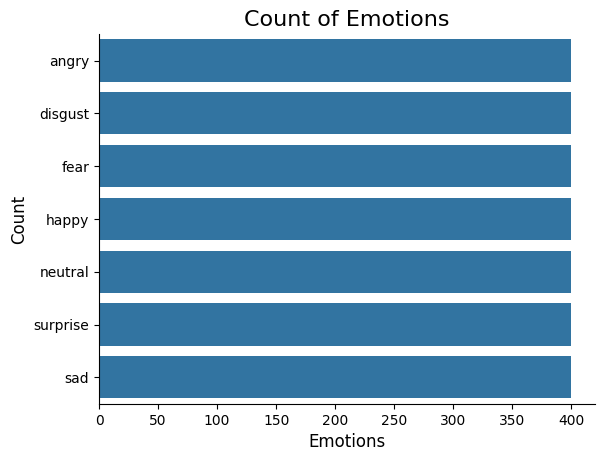

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
data,sr = librosa.load(file_path[0])
sr

22050

In [9]:
ipd.Audio(data,rate=sr)

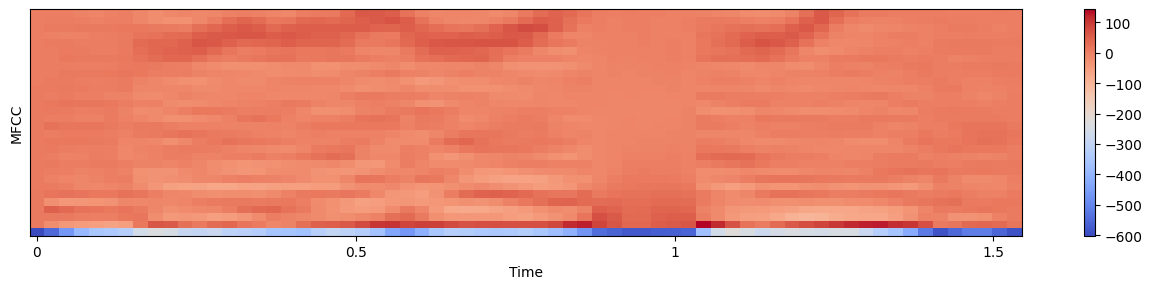

In [10]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

# Feature extraction

In [11]:
import librosa
import numpy as np

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def calculate_mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def calculate_chroma(data, sr, hop_length=512, flatten=True):
    chroma = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=hop_length)
    return np.squeeze(chroma.T) if not flatten else np.ravel(chroma.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((
        result,
        calculate_chroma(data, sr, hop_length)
    ))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)
    
    audio = np.vstack((audio, aud))
    
    return audio

In [12]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


# Noraml way to get features

In [13]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

54it [00:00, 279.44it/s]

0 audio has been processed


567it [00:01, 312.44it/s]

500 audio has been processed


1044it [00:03, 282.62it/s]

1000 audio has been processed


1536it [00:05, 265.11it/s]

1500 audio has been processed


2054it [00:07, 303.25it/s]

2000 audio has been processed


2566it [00:09, 303.71it/s]

2500 audio has been processed


2800it [00:10, 276.57it/s]

Done
Time:  10.12646069994662


# Faster way to get features

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [14]:
len(X), len(Y), data_path.Path.shape

(5600, 5600, (2800,))

# Saving features

In [15]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_tess_chroma_noaug.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1227,1228,1229,1230,1231,1232,1233,1234,1235,Emotions
0,1.000000,0.271578,0.019846,0.006083,0.004314,0.004789,0.048701,0.349700,0.193753,0.027968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,1.000000,0.271578,0.019846,0.006083,0.004314,0.004789,0.048701,0.349700,0.193753,0.027968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,1.000000,0.485108,0.064671,0.020852,0.012799,0.009731,0.010650,0.029892,0.016279,0.015059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,1.000000,0.485108,0.064671,0.020852,0.012799,0.009731,0.010650,0.029892,0.016279,0.015059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.281098,1.000000,0.460694,0.076041,0.025293,0.014295,0.009325,0.027182,0.292562,0.166902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()